<a href="https://colab.research.google.com/github/stephenbeckr/numerical-analysis-class/blob/master/Demos/Ch6_LU_vs_Cholesky.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LU vs Cholesky factorization

If a matrix $A$ is positive definite, then we can do an LU factorization, but we should do Cholesky since it's a bit faster (about 1.7x faster).

Overall, finding the Cholesky factorization of a positive definite matrix is faster than finding the LU factorization of a general matrix

Cholesky decompositions do not need to pivot. The relative speed gains over LU factorization should probably be larger on a computer with many cores (colab just has 2 cores, so we don't see too much effect)

In [45]:
import numpy as np
from scipy.linalg import *
from numpy.random import default_rng
from time import perf_counter
import matplotlib.pyplot as plt

# Helper routine to print out matrices nicely
def matprint(mat, fmt="g",roundToDecimal=3):
  # from https://gist.github.com/braingineer/d801735dac07ff3ac4d746e1f218ab75
  # Modified to round
  if roundToDecimal is not None:
    mat = np.round(mat,decimals=roundToDecimal)
  col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
  for x in mat:
    for i, y in enumerate(x):
      print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
    print("")

## Let's see how to use Scipy's LU factorization routines

In [53]:
n = 6
rng   = default_rng(123)
A = rng.standard_normal((int(n),int(n)))

LU,piv = lu_factor(A,check_finite=False)
print('LU is')
matprint(LU)
print('pivot array (weird format!) is')
print(piv)

LU is
 1.192  -0.671       1   0.136   1.532   -0.66  
-0.303  -1.434    1.53  -2.131   0.095  -0.036  
-0.262  -0.113  -1.773   0.622   1.953    0.95  
 -0.83   0.645  -0.638   2.078   3.377   0.659  
-0.534  -0.128  -0.233  -0.182   1.996  -1.542  
 0.633  -0.195  -0.534   0.436  -0.495  -0.127  
pivot array (weird format!) is
[2 5 3 3 5 5]


From the documentation of LAPACK's `dgetrf`:

PIV is INTEGER array, dimension (min(M,N))
The pivot indices; for $1 \le i \le \min(M,N)$, row $i$ of the
matrix was interchanged with row IPIV($i$).

And call the other LU function, `lu`

In [ ]:
P,L,U = lu(A,check_finite=False)
print('P^T is')
matprint(P.T)
print('L is')
matprint(L)
print('U is')
matprint(U)

## Now let's do some timing

In [54]:
rng   = default_rng()
nList = np.round(np.logspace(2.5,3.6,12))
timeLU   = []
timeLU_v2   = []
timeChol = []

for n in nList:
  A = rng.standard_normal((int(n),int(n)))

  # both lu and lu_factor exist
  tStart = perf_counter()
  LU,pivots = lu_factor(A,check_finite=False)
  timeLU.append( perf_counter() - tStart )

  tStart = perf_counter()
  P,L,U = lu(A,check_finite=False)
  timeLU_v2.append( perf_counter() - tStart )

  # make it positive semi-definite, and (with probability 1) positive definite
  A = A@A.T  

  tStart = perf_counter()
  L = cholesky(A,check_finite=False)
  timeChol.append( perf_counter() - tStart )


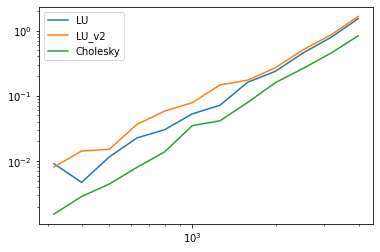

In [55]:
plt.loglog( nList, timeLU, label='LU')
plt.loglog( nList, timeLU_v2, label='LU_v2')
plt.loglog( nList, timeChol, label='Cholesky')
plt.legend()
plt.show()

On my 4-core laptop, not only are things faster, but there's more difference between the two different types of LU. My results are:

```
Time for Cholesky at largest size is 0.27839755200011496
Time for LU at largest size is 0.5116191430001891
Time for LU v2 at largest size is 0.8564363280001999
Ratio 1.8377285982743763
```



In [56]:
print("Time for Cholesky at largest size is", timeChol[-1] )
print("Time for LU at largest size is", timeLU[-1] )
print("Time for LU v2 at largest size is", timeLU_v2[-1] )
print("Ratio", timeLU[-1]/timeChol[-1] )

Time for Cholesky at largest size is 0.8303866559999733
Time for LU at largest size is 1.52171751700007
Time for LU v2 at largest size is 1.6433467480001127
Ratio 1.8325409085091549


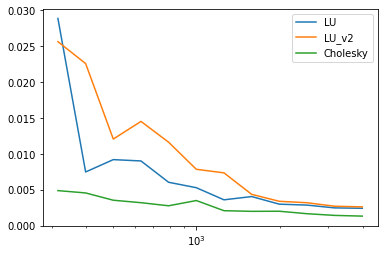

In [57]:
ref = 1e-8*nList**3
plt.semilogx( nList, timeLU/ref, label='LU')
plt.semilogx( nList, timeLU_v2/ref, label='LU_v2')
plt.semilogx( nList, timeChol/ref, label='Cholesky')

plt.legend()
plt.show()